In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
os.system('unzip ORLProcessed.zip')

512

In [3]:
# TRAIN
y_train = []
images = []
for person in os.listdir('Train'):
  label = int(person[1:])
  for file in os.listdir('Train/' + person):
    y_train.append(label)
    img = cv.imread('Train/' + person + '/' + file, 0)
    images.append(np.array(img).flatten())
x_train = np.stack(images, axis=1)

In [4]:
# TEST
y_test = []
images = []
for person in os.listdir('Test'):
  label = int(person[1:])
  for file in os.listdir('Test/' + person):
    y_test.append(label)
    img = cv.imread('Test/' + person + '/' + file, 0)
    images.append(np.array(img).flatten())
x_test = np.stack(images, axis=1)

In [5]:
print(x_train.shape) # lo pondremos por columnas, 200 imágenes de 10304 píxeles

(10304, 200)


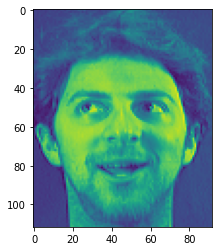

In [ ]:
plt.imshow(img) # una de las imágenes leídas en la creación de train/test
plt.show()

# PCA - EigenFaces

In [46]:
vector_promedio = x_train.mean(axis=0)
vector_promedio.shape[0]

200

In [47]:
A = x_train - vector_promedio

In [48]:
A.shape

(10304, 200)

In [49]:
C_prima = (1/A.shape[0])*np.dot(A.T,A)

In [50]:
C_prima.shape

(200, 200)

In [51]:
delta_prima, b_prima = np.linalg.eig(C_prima) # eigenvalues, egivenvectors

In [52]:
b = np.dot(A, b_prima)

In [53]:
delta = (A.shape[0]/A.shape[1])*delta_prima

In [54]:
# ordenamos eigenvalues y vectors de mayor a menor eigenvalues
eigenValuesOrdered = sorted(list(enumerate(delta)),key = lambda t: t[1], reverse=True)
idx = list(map(lambda t : t[0], eigenValuesOrdered))
b = b[:,idx]
b = b/np.linalg.norm(b,axis=0)

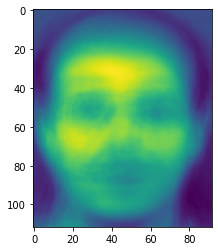

In [ ]:
plt.imshow(np.reshape(b[:,0],(112,92)))

In [55]:
def cambiarDimensionalidad(datos,b,dimensiones):
    aux = b[:,1:dimensiones+1]
    media = datos.mean(axis=0)
    imagenesResultantes = np.dot((datos-media).T, aux)
    
    return imagenesResultantes

In [56]:
x_train_cpa = cambiarDimensionalidad(x_train, b, 100)
x_test_cpa = cambiarDimensionalidad(x_test, b, 100)

In [57]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x_train_cpa,y_train) 
clf.score(x_test_cpa,y_test)

0.89

In [58]:
resultados= []
clf = KNeighborsClassifier(n_neighbors=1)
for i in range(1,200):
  x_train_cpa = cambiarDimensionalidad(x_train, b, i)
  x_test_cpa = cambiarDimensionalidad(x_test, b, i)
  clf.fit(x_train_cpa,y_train) 
  resultados.append(clf.score(x_test_cpa,y_test))

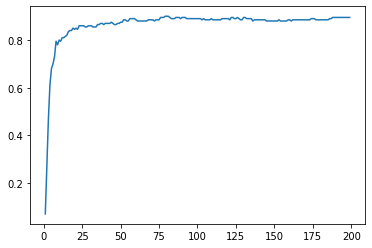

In [59]:
plt.plot(list(range(1,200)),resultados)

# LDA - FisherFaces

In [21]:
x_train_cpa = cambiarDimensionalidad(x_train, b, 200)
x_test_cpa = cambiarDimensionalidad(x_test, b, 200)

In [22]:
import scipy.linalg as scipylg

matrix = x_train_cpa.T
etiquetas = np.array(y_train)
mu = x_train_cpa.T.mean(axis = 1)
sb = np.zeros((x_train_cpa.T.shape[0],x_train_cpa.T.shape[0]))
sw = sb.copy()
for etiqueta in set(etiquetas):
    labels = np.where(etiquetas == etiqueta)
    matrix_class = x_train_cpa.T[:,labels[0]]
    mu_class = matrix_class.mean(axis = 1)
    samples_class = matrix_class.shape[1]
    sb += samples_class * (mu_class -mu) *(mu_class-mu).T
    sw += np.dot((matrix_class.T-mu_class).T, (matrix_class.T-mu_class))
Delta, b = scipylg.eig(sb, sw)
eigenValuesOrdered = sorted(list(enumerate(Delta)),key = lambda t: t[1], reverse=True)
idx = list(map(lambda t : t[0], eigenValuesOrdered))
b = b[:,idx]

In [23]:
def cambiarDimensionalidadLDA(datos,b,dimensiones):
    aux = b[:,1:dimensiones+1]
    media = datos.mean(axis=0)
    imagenesResultantes = np.dot(datos,aux)
    
    return imagenesResultantes

In [24]:
x_train_lda = cambiarDimensionalidadLDA(x_train_cpa, b, 150)
x_test_lda = cambiarDimensionalidadLDA(x_test_cpa, b, 150)

In [37]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(x_train_lda,y_train) 
clf.score(x_test_lda,y_test)

0.855

In [41]:
resultados= []
clf = KNeighborsClassifier(n_neighbors=1)
for i in range(1,50):
  x_train_lda = cambiarDimensionalidadLDA(x_train_cpa, b, i)
  x_test_lda = cambiarDimensionalidadLDA(x_test_cpa, b, i)
  clf.fit(x_train_lda,y_train) 
  resultados.append(clf.score(x_test_lda,y_test))

In [44]:
max(resultados)

0.825

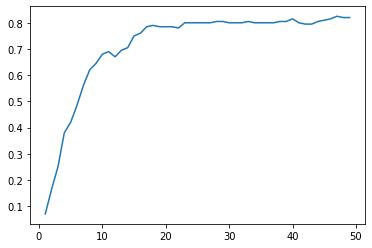

In [43]:
plt.plot(list(range(1,50)),resultados)